In [3]:
import torch
import pandas as pd

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader


In [4]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [8]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [9]:
train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract='AI')
print(len(train_dataset))

92


In [10]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/AcousticIndices_data/ReyZamuro/RZUA01_AIs.csv'
n_feat=60
10
                                                                  file
Date                                                                  
2022-09-05 10:00:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:15:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:30:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:45:00  /media/andrescastro/Seagate Backup Plus Drive/...
11
                                                                  file
Date                                                                  
2022-09-05 11:00:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:15:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:30:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:45:00  /media/andrescastro/Seagate Backup Plus Drive/...
12
           

In [11]:
x.shape

torch.Size([3, 92, 24, 60])

## Edge Creation

In [12]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [13]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=11)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True


In [14]:
graphs_ = edge_creation_nodeinfo(x,'knn', k_neigh=93)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 60], edge_index=[2, 8372]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 8372]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 8372]) connected? True
Is the graph undirected True


In [15]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

In [16]:
graphs_, adjacency_matrix = edge_creation_geoDistance(x, df_map)

In [17]:
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 60], edge_index=[2, 1400]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1400]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1400]) connected? True
Is the graph undirected True


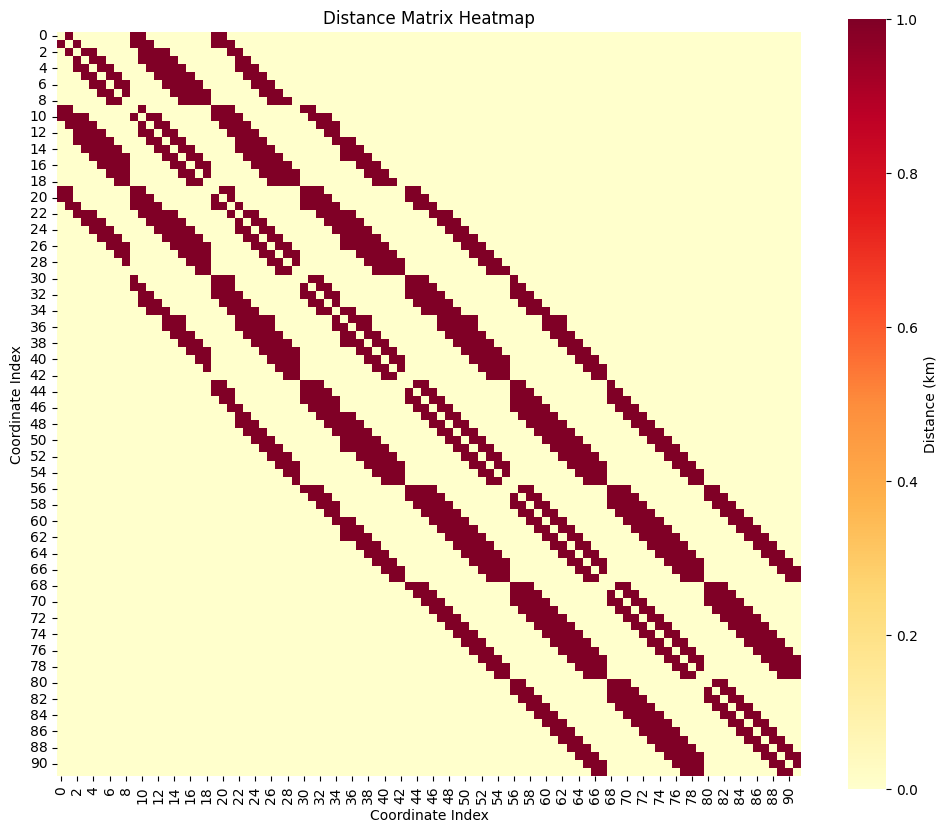

In [18]:
plot_distance_matrix_heatmap(adjacency_matrix)

In [19]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

## Organizar de acá en adelante

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

class MatrixGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim):
        super(MatrixGCN, self).__init__()
        self.conv1d = torch.nn.Conv1d(1, 64, 24, stride=24)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, embedding_dim)

    def forward(self, x, edge_index):
        x = x.transpose(1,2).flatten(1)  # Flatten the matrix features
        x = self.conv1d(x.unsqueeze(1))
        x = x.view(x.size(0),-1)
        #print(x.shape)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model and optimizer
model = MatrixGCN(in_channels=64*60, hidden_channels=2048, embedding_dim=8)#num_filters conv1d x num_original_features
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Unsupervised loss function (e.g., graph regularization)
def unsupervised_loss(embedding, edge_index):
    # This loss encourages connected nodes to have similar embeddings
    src, dst = edge_index
    distance = F.pairwise_distance(embedding[src], embedding[dst])
    return distance.mean()

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        embedding = model(graph.x.double(), graph.edge_index)
        loss = unsupervised_loss(embedding, graph.edge_index)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 12): #Oversmoothing?
    loss = train()
    if epoch % 3 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 003, Loss: 1267.4154
Epoch: 006, Loss: 549.7338
Epoch: 009, Loss: 298.1304


In [21]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        embeddings = model(graph.x.double(), graph.edge_index)

# Function to perform clustering and evaluate
def cluster_and_evaluate(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(embeddings.numpy())
    silhouette_avg = silhouette_score(embeddings.numpy(), clusters)
    return clusters, silhouette_avg

# Try different numbers of clusters
best_n_clusters = 0
best_silhouette = -1
for n_clusters in range(2, 10):  # Try 2 to 10 clusters
    clusters, silhouette_avg = cluster_and_evaluate(embeddings, n_clusters)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg}")
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters}")

# Perform final clustering with the best number of clusters
final_clusters, _ = cluster_and_evaluate(embeddings, best_n_clusters)

print("\nFinal Clustering Results:")
for i in range(best_n_clusters):
    print(f"Cluster {i}: {(final_clusters == i).sum()} nodes")

# Example: Find similar nodes
def find_similar_nodes(node_idx, top_k=5):
    node_embedding = embeddings[node_idx].unsqueeze(0)
    distances = F.cosine_similarity(node_embedding, embeddings)
    top_similar = torch.topk(distances, k=top_k+1)
    return top_similar.indices[1:].tolist()  # Exclude the node itself

# Find similar nodes for the first node
similar_nodes = find_similar_nodes(0)
print(f"\nNodes similar to node 0: {similar_nodes}")

For n_clusters = 2, the average silhouette score is : 0.4978780230927213
For n_clusters = 3, the average silhouette score is : 0.46220377525961565
For n_clusters = 4, the average silhouette score is : 0.5332615661591688
For n_clusters = 5, the average silhouette score is : 0.4536704426086449
For n_clusters = 6, the average silhouette score is : 0.48508624422134045
For n_clusters = 7, the average silhouette score is : 0.5093455886912427
For n_clusters = 8, the average silhouette score is : 0.45575945069312845
For n_clusters = 9, the average silhouette score is : 0.45180814049807216

Best number of clusters: 4

Final Clustering Results:
Cluster 0: 24 nodes
Cluster 1: 36 nodes
Cluster 2: 14 nodes
Cluster 3: 18 nodes

Nodes similar to node 0: [0, 33, 1, 43, 21]


In [22]:
graph

DataBatch(x=[92, 24, 60], edge_index=[2, 1260], batch=[92], ptr=[2])

In [23]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 8])


In [24]:
import plotly.graph_objs as go

# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

#Definint the minimun distance between points
# Define bounds (min_lat, max_lat, min_lon, max_lon)
md = 0.02 #(in kilometers)
bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))
# Convert md km to degrees
lat_step = md / 111  # Approximately 0.0018 degrees

# Calculate longitude step at the middle latitude for better accuracy
middle_lat = (bounds[0] + bounds[1]) / 2
lon_step = md / (np.cos(np.radians(middle_lat)) * 111)

# Create meshgrid
lat_range = np.arange(bounds[0], bounds[1], lat_step)
lon_range = np.arange(bounds[2], bounds[3], lon_step)


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor

#Kriging 
coords = [list(xy) for xy in zip(lats, lons)]
grid_lat, grid_lon = np.meshgrid(lat_range, lon_range)
positions_sk_krig = [list(xy) for xy in zip(grid_lat.ravel(), grid_lon.ravel())]
pipeline = Pipeline([
    #('scaler', StandardScaler()),                   # First step: Standard scaling
    ('gp', GaussianProcessRegressor(n_restarts_optimizer=5))  # Second step: Gaussian Process Regressor
])

grid_values = []

#Kriging
for t in range(embeddings.shape[1]): #APROVECHAR PARA LOS 8 VALORES DEL EMBEDDING
    values = embeddings[:,t]
    pipeline.fit(coords, values)
    Z_sk_krig = pipeline.predict(positions_sk_krig)
    grid_values.append(Z_sk_krig.reshape(grid_lat.shape))

values = np.stack(grid_values, axis=0)
values.shape

(8, 146, 244)

In [ ]:
# Create a list of data frames
grid_lat, grid_lon = np.meshgrid(lat_range, lon_range)
global_min = np.nanmin(values)
global_max = np.nanmax(values)
time_labels = np.arange(8) #tamaño de embedding
time_labels = time_labels.astype(str)
data_frames = []
for t in range(values.shape[0]):
    df = pd.DataFrame({
        'lat': grid_lat.ravel(),
        'lon': grid_lon.ravel(),
        'value': values[t].ravel()
    })
    # Create hover text labels for each point, including lat, lon, and value
    df['text'] = df.apply(lambda row: f'Lat: {row.lat:.2f}, Lon: {row.lon:.2f}, Value: {row.value:.2f}', axis=1)
    data_frames.append(df)

# Update trace and frame creation to include 'text' attribute
traces = [
    go.Scattermapbox(
        lat=df['lat'],
        lon=df['lon'],
        text=df['text'],  # Add hover text
        mode='markers',  # Display markers only
        marker=go.scattermapbox.Marker(
            color=df['value'],
            colorscale='Viridis',
            cmin=global_min,
            cmax=global_max,
            size=10,
            showscale=True if t == 0 else False
        ),
        hoverinfo='text',  # Show hover text
        name=time_labels[t]
    ) for t, df in enumerate(data_frames)
]

frames = [
    go.Frame(
        data=[
            go.Scattermapbox(
                lat=df['lat'],
                lon=df['lon'],
                text=df['text'],
                mode='markers',
                marker=go.scattermapbox.Marker(
                    color=df['value'],
                    colorscale='Viridis',
                    cmin=global_min,
                    cmax=global_max,
                    size=10
                ),
                hoverinfo='text'
            )
        ],
        name=time_labels[i]
    ) for i, df in enumerate(data_frames)
]


# Layout with mapbox and buttons
layout = go.Layout(
    mapbox=dict(
        style='open-street-map',
        zoom=12,
        center=dict(lat=np.mean(lats), lon=np.mean(lons))
    ),
    updatemenus=[{
        'type': 'buttons',
        'buttons': [{'label': 'Play', 'method': 'animate', 'args': [None]}]
    }],
    showlegend=False
)

# Create the figure
fig = go.Figure(data=traces[0], layout=layout, frames=frames)

# Slider for time control
fig.update_layout(
    sliders=[{
        'steps': [{'method': 'animate', 'label': time_labels[i], 'args': [[time_labels[i]], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}]} for i in range(len(traces))],
        'transition': {'duration': 300},
        'x': 0.1,
        'len': 0.9,
        'currentvalue': {'visible': True, 'prefix': 'Time: '}
    }]
)

fig.show()

In [ ]:
import colorsys

# Sample data
locations = df_map.reset_index().rename(columns={'index': 'name'}).to_dict('records')

def generate_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.7, 0.7) for x in range(n)]
    return list(map(lambda x: f'rgb{tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x))}', HSV_tuples))


# color_map = {0: 'red', 1: 'blue', 2:'green'}
unique_labels = list(set(final_clusters))
colors = generate_colors(len(unique_labels))
color_map = dict(zip(unique_labels, colors))

# Create traces
traces = []
for location, label in zip(locations, final_clusters):
    traces.append(
        go.Scattermapbox(
            lat=[location['latitude_IG']],
            lon=[location['longitud_IG']],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=14,
                color=color_map[label],
                opacity=0.8
            ),
            text=[f"{location['field_numb']} ({label})"],
            name=location['field_numb'],
            showlegend=True
        )
    )

# Create layout
layout = go.Layout(
    mapbox=dict(
        style="open-street-map",
        # center=dict(lat=39, lon=-98),  # Center of the US
        center=dict(lat=df_map.mean().values[0], lon=df_map.mean().values[1]),
        zoom=11.7
    ),
    showlegend=True
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

## Grafo nuevo (calcular aristas de nuevo con información de nodo) 

In [ ]:
embeddings.shape

torch.Size([92, 8])

In [ ]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=11)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 8], edge_index=[2, 1222]) connected? True
Is the graph undirected True


In [ ]:
graphs[0].edge_index.shape

torch.Size([2, 1260])

In [ ]:
graphs_[0].edge_index.shape

torch.Size([2, 1222])

In [ ]:
from utils import edge_index_to_adjacency

In [ ]:
adj_init = edge_index_to_adjacency(graphs[0].edge_index)

In [ ]:
adj_final = edge_index_to_adjacency(graphs_[0].edge_index)

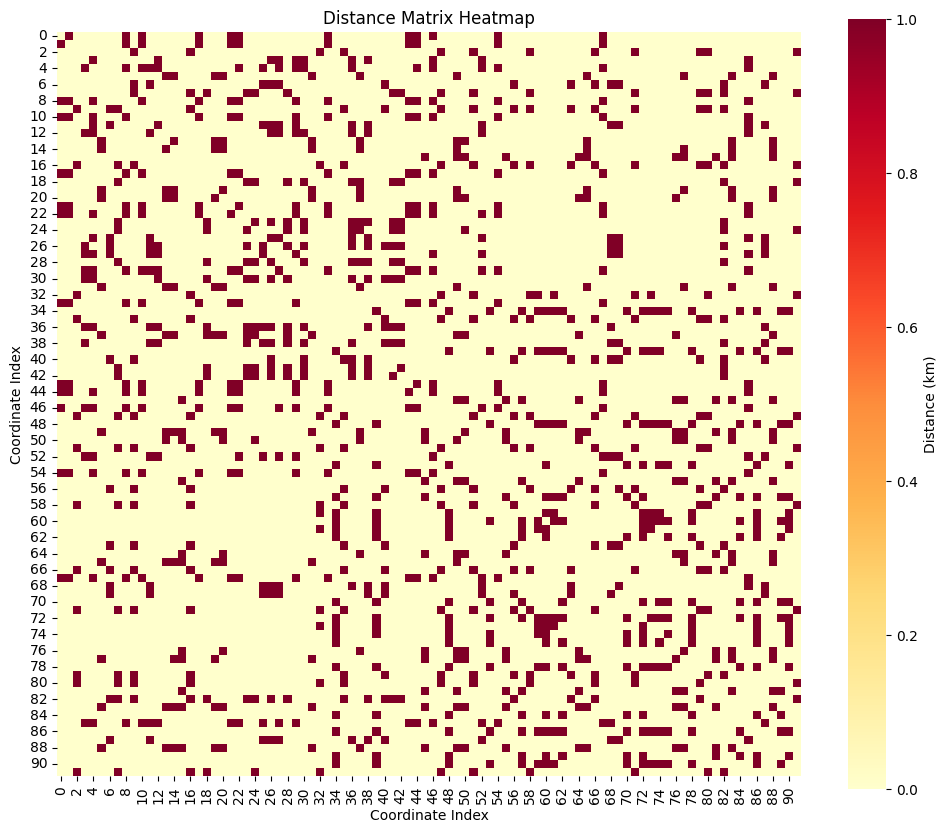

In [ ]:
plot_distance_matrix_heatmap(adj_init)

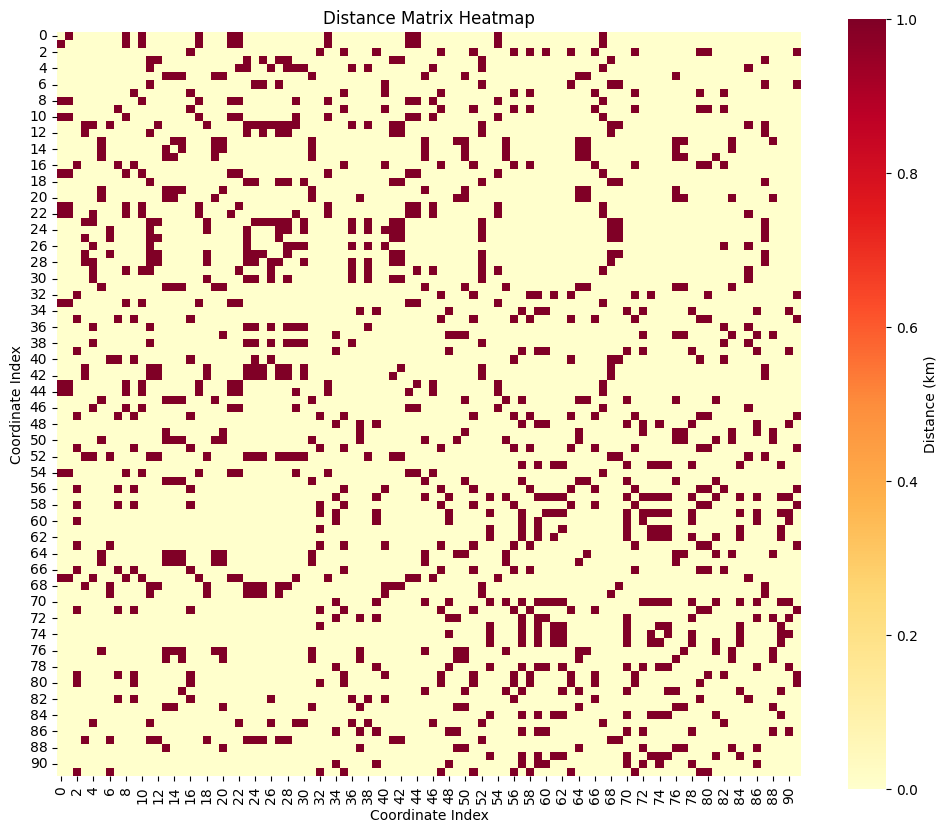

In [ ]:
plot_distance_matrix_heatmap(adj_final)

In [ ]:
df_map

latitude_IG  longitud_IG
field_numb                          
RZUA01         3.555860   -73.411659
RZUA02         3.552269   -73.411659
RZUA04         3.544981   -73.411514
RZUA05         3.541357   -73.411571
RZUA06         3.537848   -73.411489
...                 ...          ...
RZUH09         3.527172   -73.386423
RZUH10         3.523509   -73.386542
RZUH11         3.519590   -73.386250
RZUH12         3.516031   -73.386458
RZUH13         3.512511   -73.386398

[92 rows x 2 columns]

In [ ]:
import geopandas as gpd
import networkx as nx
import matplotlib.colors as mcolors


In [ ]:
#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [ ]:
coordinates = same_posicion_data(df_map)

In [ ]:
graphs_[0]

Data(x=[92, 8], edge_index=[2, 1222])

In [ ]:
coordinates

array([[-73.411659 ,   3.55586  ],
       [-73.4116585,   3.5522694],
       [-73.4115144,   3.5449814],
       [-73.4115714,   3.541357 ],
       [-73.4114886,   3.5378482],
       [-73.4113688,   3.53451  ],
       [-73.4116395,   3.5306852],
       [-73.4120533,   3.5270875],
       [-73.4117267,   3.5232767],
       [-73.4080305,   3.5558748],
       [-73.4079323,   3.548788 ],
       [-73.408125 ,   3.5452143],
       [-73.4080353,   3.5414035],
       [-73.4073639,   3.5377706],
       [-73.4079365,   3.5339204],
       [-73.4078713,   3.5305841],
       [-73.4079213,   3.5269836],
       [-73.4083064,   3.5235147],
       [-73.4076433,   3.520385 ],
       [-73.4046697,   3.5556609],
       [-73.4042293,   3.5522801],
       [-73.4044693,   3.5486698],
       [-73.4043366,   3.5414907],
       [-73.4043351,   3.537707 ],
       [-73.4044158,   3.5340425],
       [-73.404327 ,   3.5306657],
       [-73.4042486,   3.5269262],
       [-73.4041044,   3.5234838],
       [-73.4044419,

In [ ]:
graphs_[0]

Data(x=[92, 8], edge_index=[2, 1222])

In [ ]:
def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges
    edges = data.edge_index.t().numpy()
    G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [ ]:
G = pyg_to_networkx(graphs[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [ ]:
edge_weights = [1 for u, v in G.edges()]

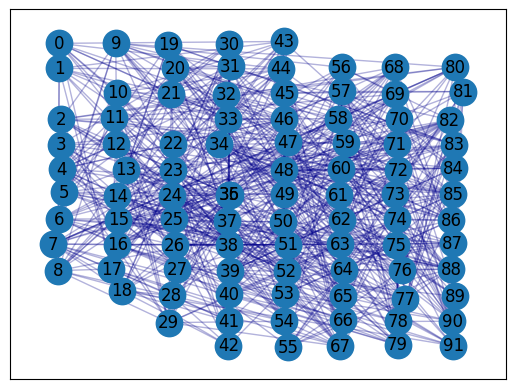

In [ ]:
# Dibujar los nodos del grafo con tamaño personalizado
node_size = 400
# node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: node for node in G.nodes()}
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black')

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

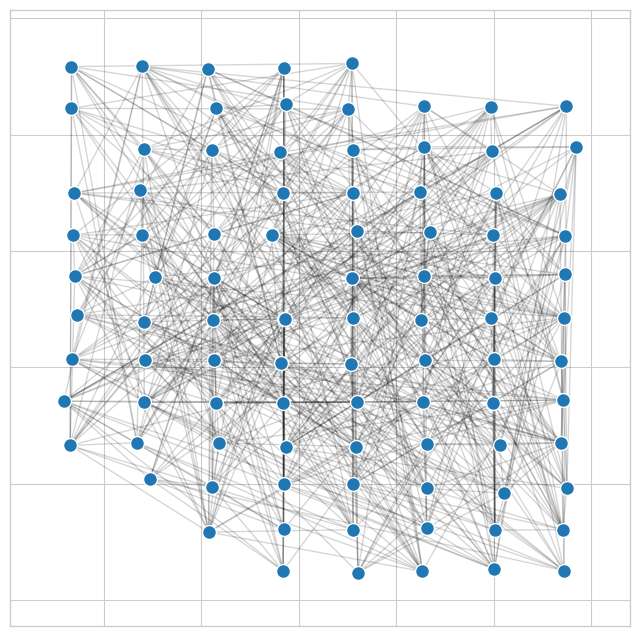

In [ ]:
with plt.style.context("seaborn-v0_8-whitegrid"):
    fig, ax = plt.subplots(figsize=(8,8))
    nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="white", linewidths=1)
    nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.1618, ax=ax)

In [ ]:
from datashader.bundling import hammer_bundle

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
nodes_py = [[name, a[0], a[1]] for name, a in zip(nodes, positions.values())]
ds_nodes = pd.DataFrame(nodes_py, columns=['name', 'x', 'y'])       

ds_edges_py = [[n0, n1] for (n0, n1) in G.edges]
ds_edges = pd.DataFrame(ds_edges_py, columns=['source', 'target'])

hb = hammer_bundle(ds_nodes, ds_edges)

NameError: name 'nodes' is not defined

In [ ]:
hb.plot(x="x", y="y", figsize=(9,9))

In [ ]:
with plt.style.context("seaborn-v0_8-whitegrid"):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(hb.x, hb.y, 'y', zorder=1, linewidth=3)
    nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="white", linewidths=1)
    nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.1618, ax=ax)